# Synthetic Data Generation with GWKokab

Welcome to this Python notebook, where we'll learn how to leverage GWKokab to generate synthetic data, which is essential for training and testing machine learning models in the context of gravitational-wave astronomy. Let's get started and discover how GWKokab can help us generate high-quality synthetic data!

In this tutorial we are generating data from Normal distribution with known mean and standard deviation, for each mass. We can think of it as,

$$
    m_1\sim \mathcal{N}(\mu_1, \sigma_1^2)\qquad
    m_2\sim \mathcal{N}(\mu_2, \sigma_2^2),
$$

where $\mu_1=100M_\odot$, $\mu_2=30M_\odot$, $\sigma_1=4$, and $\sigma_2=5$ are the mean and standard deviation of the Normal distribution for the primary and secondary mass, respectively.

*Note: These values are arbitrary and does not hold any physical significance.*


To simulate the measurement error in the data, we will add a simple Gaussian noise to the masses, and to make it more realistic, we will add what we call Banana Noise. The Banana Noise is from [Model-independent inference on compact-binary observations](https://doi.org/10.1093/mnras/stw2883). It is added to the [chirp mass](https://en.wikipedia.org/wiki/Chirp_mass) and [symmetric mass ratio](https://en.wikipedia.org/wiki/Chirp_mass#Definition_from_component_masses) of the binary system.

## Environment Variables

GWKokab at its core used JAX for fast computation. To setup the behavior of JAX based on the accelerator you are using, you have to set the environment variables. Here are the environment variables that you can set:

In [1]:
import os

os.environ["NPROC"] = "4"
os.environ["intra_op_parallelism_threads"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Necessary Imports

Let's start by importing the necessary libraries.

In [2]:
from pprint import pprint

import numpyro
from IPython.display import Image, display
from jaxtyping import Array, Bool

from gwkokab.errors import banana_error_m1_m2
from gwkokab.parameters import PRIMARY_MASS_SOURCE, SECONDARY_MASS_SOURCE
from gwkokab.population import (
    ModelMeta,
    NoisePopInfo,
    PopInfo,
    PopulationFactory,
    run_noise_factory,
)

/home/gradf/miniforge3/envs/gwkenv/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
[Loading lalsimutils.py : MonteCarloMarginalization version]
  scipy :  1.13.1
  numpy :  1.26.4


People make typos all the time, and to avoid that, we have predefined the physical parameters in the [`gwkokab.parameters`](https://github.com/gwkokab/gwkokab/blob/b66c042240dfc5d1529b34579488c507219cd967/gwkokab/_src/parameters/parameters.py#L110-L247). They are more than the predefined parameters names, we will see this later.

In [3]:
m1_source = PRIMARY_MASS_SOURCE().name
m2_source = SECONDARY_MASS_SOURCE().name
print(m1_source, m2_source)

mass_1_source mass_2_source


In order to convey the models to GWKokab we need to pack them into a dataclass called `gwkokab.population.ModelMeta`. This dataclass has the following fields:

- `NAME`: This is the reference to the [`numpyro.distributions.Distribution`](https://num.pyro.ai/en/stable/distributions.html#distribution) object.
- `OUTPUT`: List of outputs of the models in order.
- `PARAMETERS`: dictionary of parameters of the model.
- `SAVE_AS`: If you want to save any value in the `PARAMETERS` dictionary, you can specify it here.

In [4]:
m1_model_meta = ModelMeta(
    NAME=numpyro.distributions.Normal,
    OUTPUT=[m1_source],
    PARAMETERS={"loc": 100, "scale": 4, "validate_args": True},
    SAVE_AS={"loc": "mean_mass_1", "scale": "sigma_mass_1"},
)
m2_model_meta = ModelMeta(
    NAME=numpyro.distributions.Normal,
    OUTPUT=[m2_source],
    PARAMETERS={"loc": 30, "scale": 5, "validate_args": True},
    SAVE_AS={"loc": "mean_mass_2", "scale": "sigma_mass_2"},
)
pprint(m1_model_meta)
pprint(m2_model_meta)

ModelMeta(NAME=<class 'numpyro.distributions.continuous.Normal'>,
          PARAMETERS={'loc': 100, 'scale': 4, 'validate_args': True},
          OUTPUT=['mass_1_source'],
          SAVE_AS={'loc': 'mean_mass_1', 'scale': 'sigma_mass_1'})
ModelMeta(NAME=<class 'numpyro.distributions.continuous.Normal'>,
          PARAMETERS={'loc': 30, 'scale': 5, 'validate_args': True},
          OUTPUT=['mass_2_source'],
          SAVE_AS={'loc': 'mean_mass_2', 'scale': 'sigma_mass_2'})


There is another dataclass `gwkokab.population.PopInfo`, that contains essential information required for the synthetic population generation. You can refer to documentation for more information.

In [5]:
popinfo = PopInfo(
    ROOT_DIR=r"data",
    EVENT_FILENAME="event_{}",
    CONFIG_FILENAME="configuration",
    RATE=1e2,
    NUM_REALIZATIONS=2,
    VT_FILE="neural_vt_1_200_1000.eqx",
    VT_PARAMS=[m1_source, m2_source],
    TIME=365.25,
)

pprint(popinfo)

PopInfo(ROOT_DIR='data',
        EVENT_FILENAME='event_{}',
        CONFIG_FILENAME='configuration',
        RATE=100.0,
        TIME=365.25,
        VT_FILE='neural_vt_1_200_1000.eqx',
        VT_PARAMS=['mass_1_source', 'mass_2_source'],
        NUM_REALIZATIONS=2)


Often we want to put an overall constraint on the population, for example, the primary mass should be greater than the secondary mass. We can do this by defining a function that takes the population as input and returns a boolean value. This function is then passed to the `gwkokab.population.PopulationFactory`.

In [6]:
def constraint(x: Array) -> Bool:
    m1 = x[..., 0]
    m2 = x[..., 1]
    mask = m2 <= m1
    mask &= m2 > 0.0
    mask &= m1 > 0.0
    return mask


popfactory = PopulationFactory(
    [m1_model_meta, m2_model_meta],
    popinfo,
    seperate_injections=True,
    constraint=constraint,
)

With all set up, we can now generate the synthetic data.

In [7]:
popfactory.generate_realizations()

To add noise to the data, we have to make a `gwkokab.population.NoisePopInfo` object and pass the essential information to it. The noise is added to the data by calling the `run_noise_factory` function over the `gwkokab.population.NoisePopInfo` object.

In [8]:
for i in range(popinfo.NUM_REALIZATIONS):
    noisepopinfo = NoisePopInfo(
        FILENAME_REGEX=rf"data/realization_{i}/injections/event_*.dat",
        OUTPUT_DIR=rf"data/realization_{i}" + r"/posteriors/event_{}.dat",
        HEADER=[m1_source, m2_source],
        SIZE=2000,
        ERROR_FUNCS={
            (m1_source, m2_source): lambda x, size, key: banana_error_m1_m2(
                x, size, key, scale_Mc=1.0, scale_eta=1.0
            ),
        },
    )

    run_noise_factory(noisepopinfo)

## Visualizing the Data

Finally, we can visualize the data. You can use `matplotlib` or any other library of your choice to visualize the data. For your convenience, GWKokab is equipped with command line tools to visualize the data.

In [9]:
!mkdir plots

mkdir: cannot create directory ‘plots’: File exists


/home/gradf/miniforge3/envs/gwkenv/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [10]:
!gwk_scatter2d -h

[Loading lalsimutils.py : MonteCarloMarginalization version]
  scipy :  1.13.1
  numpy :  1.26.4
usage: gwk_scatter2d [-h] -d DATA -o OUTPUT -x X_VALUE_COLUMN_INDEX -y
                     Y_VALUE_COLUMN_INDEX [-t TITLE] [-xl XLABEL] [-yl YLABEL]

Scatter 2D plotter.

options:
  -h, --help            show this help message and exit
  -d DATA, --data DATA  data file path. Only .dat files are supported.
                        (default: None)
  -o OUTPUT, --output OUTPUT
                        output file path (default: None)
  -x X_VALUE_COLUMN_INDEX, --x-value-column-index X_VALUE_COLUMN_INDEX
                        index of the x-axis values (default: None)
  -y Y_VALUE_COLUMN_INDEX, --y-value-column-index Y_VALUE_COLUMN_INDEX
                        index of the y-axis values (default: None)
  -t TITLE, --title TITLE
                        title of the plot (default: None)
  -xl XLABEL, --xlabel XLABEL
                        label of the x-axis (default: x)
  -yl YLABEL, --ylabel

[Loading lalsimutils.py : MonteCarloMarginalization version]
  scipy :  1.13.1
  numpy :  1.26.4


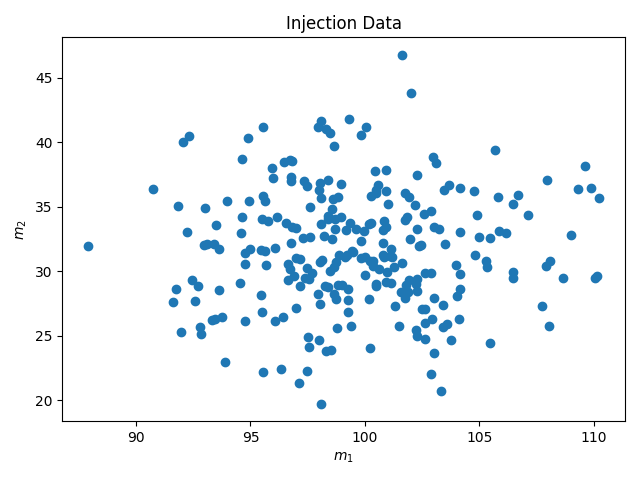

In [11]:
!gwk_scatter2d \
    --data data/realization_0/injections.dat \
    --output plots/m1m2_inj_0.png \
    --x-value-column-index 0 \
    --y-value-column-index 1 \
    --xlabel "\$m_1\$" \
    --ylabel "\$m_2\$" \
    --title "Injection Data"
display(Image(filename="plots/m1m2_inj_0.png"))

In [12]:
!gwk_batch_scatter2d -h

[Loading lalsimutils.py : MonteCarloMarginalization version]
  scipy :  1.13.1
  numpy :  1.26.4
usage: gwk_batch_scatter2d [-h] -d DATA_REGEX -o OUTPUT -x
                           X_VALUE_COLUMN_INDEX -y Y_VALUE_COLUMN_INDEX
                           [-t TITLE] [-xl XLABEL] [-yl YLABEL]
                           [-s SCATTER_SIZE] [-a ALPHA] [-m MARKER]

Scatter 2D plotter.

options:
  -h, --help            show this help message and exit
  -d DATA_REGEX, --data-regex DATA_REGEX
                        regex pattern for the data files. Only .dat files are
                        supported. (default: None)
  -o OUTPUT, --output OUTPUT
                        output file path (default: None)
  -x X_VALUE_COLUMN_INDEX, --x-value-column-index X_VALUE_COLUMN_INDEX
                        index of the x-axis values (default: None)
  -y Y_VALUE_COLUMN_INDEX, --y-value-column-index Y_VALUE_COLUMN_INDEX
                        index of the y-axis values (default: None)
  -t TITLE, --title T

[Loading lalsimutils.py : MonteCarloMarginalization version]
  scipy :  1.13.1
  numpy :  1.26.4


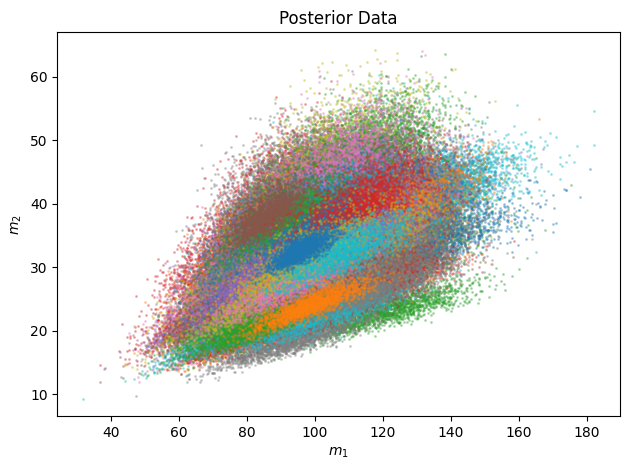

In [13]:
!gwk_batch_scatter2d \
    --data "data/realization_0/posteriors/event_*.dat" \
    --output plots/m1m2_batch_0.png \
    --x-value-column-index 0 \
    --y-value-column-index 1 \
    --xlabel "\$m_1\$" \
    --ylabel "\$m_2\$" \
    --title "Posterior Data"
display(Image(filename="plots/m1m2_batch_0.png"))